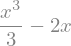

In [3]:
# solo por usar sympy

import sympy as sym
from sympy.abc import x
sym.init_printing()
sym.integrate(x**2-2, x)

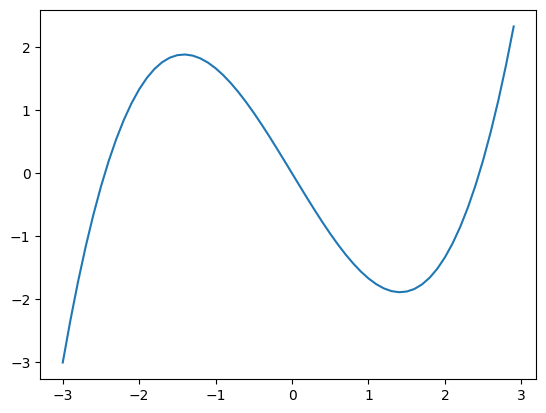

In [4]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(-3,3,.1)  # from -3 to 3 in steps of .1
plt.plot(x,x**3/3-2*x)

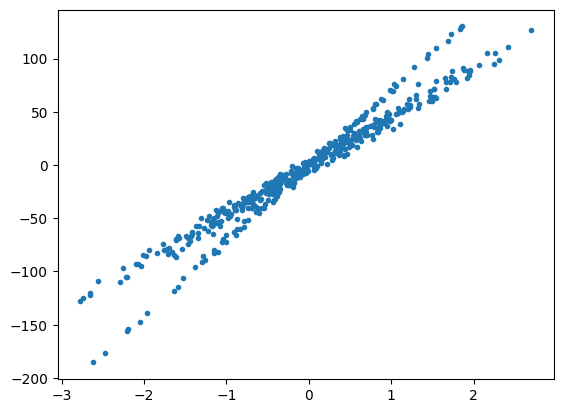

In [5]:
from sklearn import linear_model, datasets

n_samples = 500
X, y = datasets.make_regression(n_samples=n_samples,
                                n_features=1,
                                n_informative=2, 
                                noise=5,
                                random_state=0) #2)
n_outliers=100
X[:n_outliers], y[:n_outliers] = datasets.make_regression(n_samples=n_outliers,
                                n_features=1,
                                n_informative=2, 
                                noise=2,
                                random_state=61)
y=np.expand_dims(y,axis=1)
plt.scatter(X[:],y[:], marker='.')


In [6]:

#-------------------------------------------------------------
def grad_quadratic(theta, f_params):
    '''
    Gradiente de la funcion de costo 
           sum_i (theta@x[i]-y[i])**2
    '''    
    X = f_params['X']
    y = f_params['y']

    err=theta[0]*X+theta[1]-y
    partial0=err
    partial1=X*partial0
    gradient= np.concatenate((partial1, partial0), axis=1)
    return np.sum(gradient, axis=1)
#-------------------------------------------------------------
def grad_exp(theta, f_params):
    '''
    Gradiente de la funcion de costo 
           sum_i 1-exp(-k(theta@x[i]-y[i])**2)
    '''
    kappa= f_params['kappa']
    X    = f_params['X']
    y    = f_params['y']
    err=theta[0]*X+theta[1]-y
    partial0=err*np.exp(-kappa*err**2)
    partial1=X*partial0
    gradient= np.concatenate((partial1, partial0), axis=1)
    return np.mean(gradient, axis=0)
#-------------------------------------------------------------

In [8]:
def GD(theta=[], grad=None, gd_params={}, f_params={}):
    '''
    Descenso de gradiente
    
    Parámetros
    -----------
    theta     :   condicion inicial
    grad      :   función que calcula el gradiente
    gd_params :   lista de parametros para el algoritmo de descenso, 
                     nIter = gd_params[0] número de iteraciones
                     alpha = gd_params[1] tamaño de paso alpha

    f_params  :   lista de parametros para la funcion objetivo
                     kappa = f_params['kappa'] parametro de escala (rechazo de outliers)
                     X     = f_params['X'] Variable independiente
                     y     = f_params['y'] Variable dependiente                   
                  
    Regresa
    -----------
    Theta     :   trayectoria de los parametros
                     Theta[-1] es el valor alcanzado en la ultima iteracion
    '''
    
    nIter = gd_params['nIter'] 
    alpha = gd_params['alpha']
    Theta=[]
    for t in range(nIter):
        p = grad(theta,f_params=f_params)
        theta = theta - alpha*p
        Theta.append(theta)
    return np.array(Theta)


In [9]:
def SGD(theta=[], grad=None, gd_params=[], f_params=[]):
    '''
    Descenso de gradiente estocástico
    
    Parámetros
    -----------
    theta     :   condicion inicial
    grad      :   funcion que calcula el gradiente
    
    gd_params :   lista de parametros para el algoritmo de descenso, 
                      nIter = gd_params['nIter'] número de iteraciones
                      alpha = gd_params['alpha'] tamaño de paso alpha
                      batch_size = gd_params['batch_size'] tamaño de la muestra
                      
    f_params  :   lista de parametros para la funcion objetivo, 
                      kappa = f_params['kappa'] parametro de escala (rechazo de outliers)
                      X     = f_params['X'] Variable independiente
                      y     = f_params['y'] Variable dependiente                   
                  
    Regresa
    -----------
    Theta     :   trayectoria de los parametros
                     Theta[-1] es el valor alcanzado en la ultima iteracion
    '''
    (high,dim) = f_params['X'].shape
    batch_size = gd_params['batch_size']
    
    nIter      = gd_params['nIter']
    alpha      = gd_params['alpha']
        
    Theta=[]
    for t in range(nIter):
        # Set of sampled indices
        smpIdx = np.random.randint(low=0, high=high, size=batch_size, dtype='int32')
        # sample 
        smpX = f_params['X'][smpIdx]
        smpy = f_params['y'][smpIdx]
        # parametros de la funcion objetivo
        smpf_params ={'kappa' : f_params['kappa'], 
                      'X'     : smpX , 
                      'y'     : smpy}
        
        p = grad(theta,f_params=smpf_params)
        theta = theta - alpha*p
        Theta.append(theta)
        
    return np.array(Theta)

In [10]:
def MGD(theta=[], grad=None, gd_params={}, f_params={}):
    '''
    Descenso de gradiente con momento (inercia)
    
    Parámetros
    -----------
    theta     :   condicion inicial
    grad      :   funcion que calcula el gradiente
    gd_params :   lista de parametros para el algoritmo de descenso, 
                      nIter = gd_params['nIter'] número de iteraciones
                      alpha = gd_params['alpha'] tamaño de paso alpha
                      eta   = gd_params['eta']  parametro de inercia (0,1]
    f_params  :   lista de parametros para la funcion objetivo, 
                      kappa = f_params['kappa'] parametro de escala (rechazo de outliers)
                      X     = f_params['X'] Variable independiente
                      y     = f_params['y'] Variable dependiente                   

    Regresa
    -----------
    Theta     :   trayectoria de los parametros
                     Theta[-1] es el valor alcanzado en la ultima iteracion
    '''
    nIter = gd_params['nIter']
    alpha = gd_params['alpha'] 
    eta   = gd_params['eta']
    p_old = np.zeros(theta.shape)
    Theta=[]
    for t in range(nIter):
        g = grad(theta, f_params=f_params)
        p = g + eta*p_old
        theta = theta - alpha*p
        p_old=p
        Theta.append(theta)
    return np.array(Theta)

In [11]:
def NAG(theta=[], grad=None, gd_params={}, f_params={}):
    '''
    Descenso acelerado de Nesterov
    
    Parámetros
    -----------
    theta     :   condicion inicial
    grad      :   funcion que calcula el gradiente
    gd_params :   lista de parametros para el algoritmo de descenso, 
                      nIter = gd_params['nIter'] número de iteraciones
                      alpha = gd_params['alpha'] tamaño de paso alpha
                      eta   = gd_params['eta']  parametro de inercia (0,1]
    f_params  :   lista de parametros para la funcion objetivo, 
                      kappa = f_params['kappa'] parametro de escala (rechazo de outliers)
                      X     = f_params['X'] Variable independiente
                      y     = f_params['y'] Variable dependiente                   

    Regresa
    -----------
    Theta     :   trayectoria de los parametros
                     Theta[-1] es el valor alcanzado en la ultima iteracion
    '''
    nIter = gd_params['nIter']
    alpha = gd_params['alpha'] 
    eta   = gd_params['eta']
    p     = np.zeros(theta.shape)
    Theta=[]
    
    for t in range(nIter):
        pre_theta = theta - 2.0*alpha*p
        g = grad(pre_theta, f_params=f_params)
        p = g + eta*p
        theta = theta - alpha*p
        Theta.append(theta)
    return np.array(Theta)

In [12]:
def ADADELTA(theta=[], grad=None, gd_params={}, f_params={}):
    '''
    Descenso de Gradiente Adaptable (ADADELTA) 
    
    Parámetros
    -----------
    theta     :   condicion inicial
    grad      :   funcion que calcula el gradiente
    gd_params :   lista de parametros para el algoritmo de descenso, 
                      nIter    = gd_params['nIter'] número de iteraciones
                      alphaADA = gd_params['alphaADADELTA'] tamaño de paso alpha
                      eta      = gd_params['eta']  parametro adaptación del alpha
    f_params  :   lista de parametros para la funcion objetivo, 
                      kappa = f_params['kappa'] parametro de escala (rechazo de outliers)
                      X     = f_params['X'] Variable independiente
                      y     = f_params['y'] Variable dependiente                   

    Regresa
    -----------
    Theta     :   trayectoria de los parametros
                     Theta[-1] es el valor alcanzado en la ultima iteracion
    '''
    epsilon= 1e-8
    nIter    = gd_params['nIter']
    alpha    = gd_params['alphaADADELTA'] 
    eta      = gd_params['eta']
    G        = np.zeros(theta.shape)
    g        = np.zeros(theta.shape) 
    Theta=[]
    for t in range(nIter):
        g = grad(theta, f_params=f_params)
        G = eta*g**2 + (1-eta)*G
        p = 1.0/(np.sqrt(G)+epsilon)*g
        theta = theta - alpha * p
        Theta.append(theta)
    return np.array(Theta)

In [13]:
import numpy as np
def ADAM(theta=[], grad=None, gd_params={}, f_params={}):
    '''
    Descenso de Gradiente Adaptable con Momentum(A DAM) 
    
    Parámetros
    -----------
    theta     :   condicion inicial
    grad      :   funcion que calcula el gradiente
    gd_params :   lista de parametros para el algoritmo de descenso, 
                      nIter    = gd_params['nIter'] número de iteraciones
                      alphaADA = gd_params['alphaADAM'] tamaño de paso alpha
                      eta1     = gd_params['eta1'] factor de momentum para la direccion 
                                 de descenso (0,1)
                      eta2     = gd_params['eta2'] factor de momentum para la el 
                                 tamaño de paso (0,1)
    f_params  :   lista de parametros para la funcion objetivo, 
                      kappa = f_params['kappa'] parametro de escala (rechazo de outliers)
                      X     = f_params['X'] Variable independiente
                      y     = f_params['y'] Variable dependiente                   

    Regresa
    -----------
    Theta     :   trayectoria de los parametros
                     Theta[-1] es el valor alcanzado en la ultima iteracion
    '''
    epsilon= 1e-8
    nIter    = gd_params['nIter']
    alpha    = gd_params['alphaADAM'] 
    eta1     = gd_params['eta1']
    eta2     = gd_params['eta2']
    p        = np.zeros(theta.shape)
    v        = np.zeros(theta.shape)
    Theta    = []
    eta1_t = eta1
    eta2_t = eta2
    for t in range(nIter):
        g  = grad(theta, f_params=f_params)
        p  = eta1*p + (1.0 - eta1)*g
        v  = eta2*v + (1.0 - eta2)*(g**2)
        eta1_t = eta1**t
        eta2_t = eta2**t
        p = p/(1.0 - eta1_t)
        v = v/(1.0 - eta2_t)
        theta = theta - alpha * p / (np.sqrt(v) + epsilon)
        eta1_t *= eta1
        eta2_t *= eta2
        Theta.append(theta)
    return np.array(Theta)